In [344]:
import pickle 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [345]:
def ass_info(week_assignments):
    over_ass = 0
    empty = 0
    lawyers = set()
    for ass in week_assignments:
        lawyers.update(ass)
        if len(ass) > 1:
            over_ass += len(ass) - 1
        elif len(ass) == 0:
            empty += 1
    return len(lawyers), over_ass, empty

def get_load(week):
    return sum(map(lambda x: x[0], week))

In [346]:
def get_data(assignments, spr, sr, lawyers_time, sa, weeks):
    greedy_fos = {}
    greedy_pfos = {}
    greedy_ass = {}
    saa_fos = {}
    saa_pfos = {}
    saa_ass = {}
    services = {}
    mode1 = "saa"
    mode2 = "greedy"


    for rate in assignments:
        for lamb in assignments[rate]:
            saa_sr = sr[rate][lamb][mode1]
            saa_fo = {week: sum(ratings) for week, ratings in saa_sr.items()}
            saa_fo = np.cumsum(list(saa_fo.values()))

            greedy_sr = sr[rate][lamb][mode2]
            greedy_fo = {week: sum(ratings) for week, ratings in greedy_sr.items()}
            greedy_fo = np.cumsum(list(greedy_fo.values()))


            saa_spr = spr[rate][lamb][mode1]
            saa_penalized_fo = {week: sum(ratings) for week, ratings in saa_spr.items()}
            saa_penalized_fo = np.cumsum(list(saa_penalized_fo.values()))

            greedy_spr = spr[rate][lamb][mode2]
            greedy_penalized_fo = {week: sum(ratings) for week, ratings in greedy_spr.items()}
            greedy_penalized_fo = np.cumsum(list(greedy_penalized_fo.values()))


            saa_assignment = assignments[rate][lamb][saa]
            greedy_assignment = assignments[rate][lamb][greedy]
            weeks = list(assignments[rate][lamb][mode1].keys())
            info_per_week = np.array([(len(saa_assignment[week]), 
                             get_load(sa[rate][lamb][mode1][week])) for week in weeks])
            greedy_per_week = np.array([ass_info(greedy_assignment[week]) for week in weeks])
            saa_per_week = np.array([ass_info(saa_assignment[week]) for week in weeks])


            greedy_fos[(rate, lamb)] = greedy_fo
            greedy_pfos[(rate, lamb)] = greedy_penalized_fo
            greedy_ass[(rate, lamb)] = greedy_per_week
            saa_fos[(rate, lamb)] = saa_fo
            saa_pfos[(rate, lamb)] = saa_penalized_fo
            saa_ass[(rate, lamb)] = saa_per_week
            services[(rate, lamb)] = info_per_week
    return (greedy_fos, greedy_pfos, greedy_ass), (saa_fos, saa_pfos, saa_ass), services

# 130 percent #

In [372]:
with open('results/130percent/assignments.pickle', 'rb') as file:
    assignments = pickle.load(file)
    
with open('results/130percent/spr.pickle', 'rb') as file:
    spr = pickle.load(file)

with open('results/130percent/sr.pickle', 'rb') as file:
    sr = pickle.load(file)
    
with open('results/130percent/time_lawyers.pickle', 'rb') as file:
    lawyers_time = pickle.load(file)
    
with open('results/130percent/sa.pickle', 'rb') as file:
    sa = pickle.load(file)
    
mode1, mode2 = 'saa', 'greedy'

In [373]:
rates = list(spr.keys())
lambs = list(spr[1.25].keys())
saa, greedy = list(spr[1.25][0.2].keys())
weeks = list(spr[1.25][0.2]['saa'].keys())

print(rates)
print(lambs)
print(saa, greedy)
print(weeks)

[1.25, 4]
[0.2, 0.5, 0.8]
saa greedy
[1, 2, 4, 5, 8, 9, 10, 11, 12, 15]


In [374]:
greedy_info, saa_info, services = get_data(assignments, spr, sr, lawyers_time, sa, weeks)
greedy_fos, greedy_pfos, greedy_ass = greedy_info
saa_fos, saa_pfos, saa_ass = saa_info

### rate = 1.25 ###

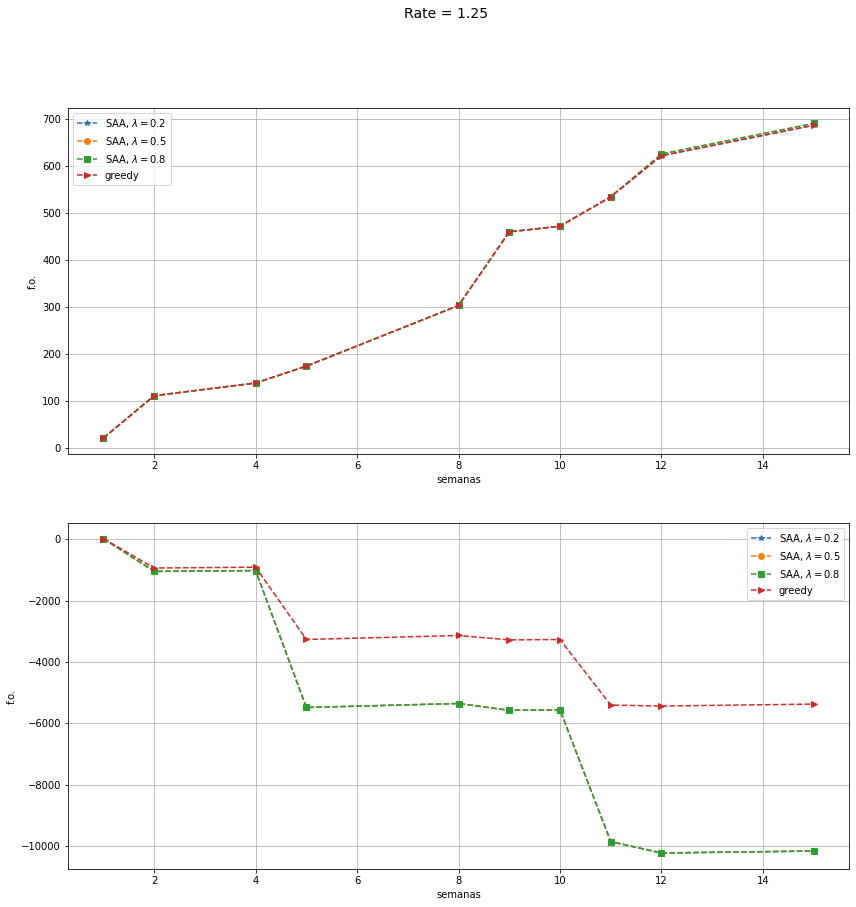

In [375]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 14))

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])
    
    ax3.plot(weeks, saa_pfos[rate, lamb], symbols[i])

ax3.plot(weeks, greedy_pfos[rate, lamb], "-->")
ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

ax3.grid()
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

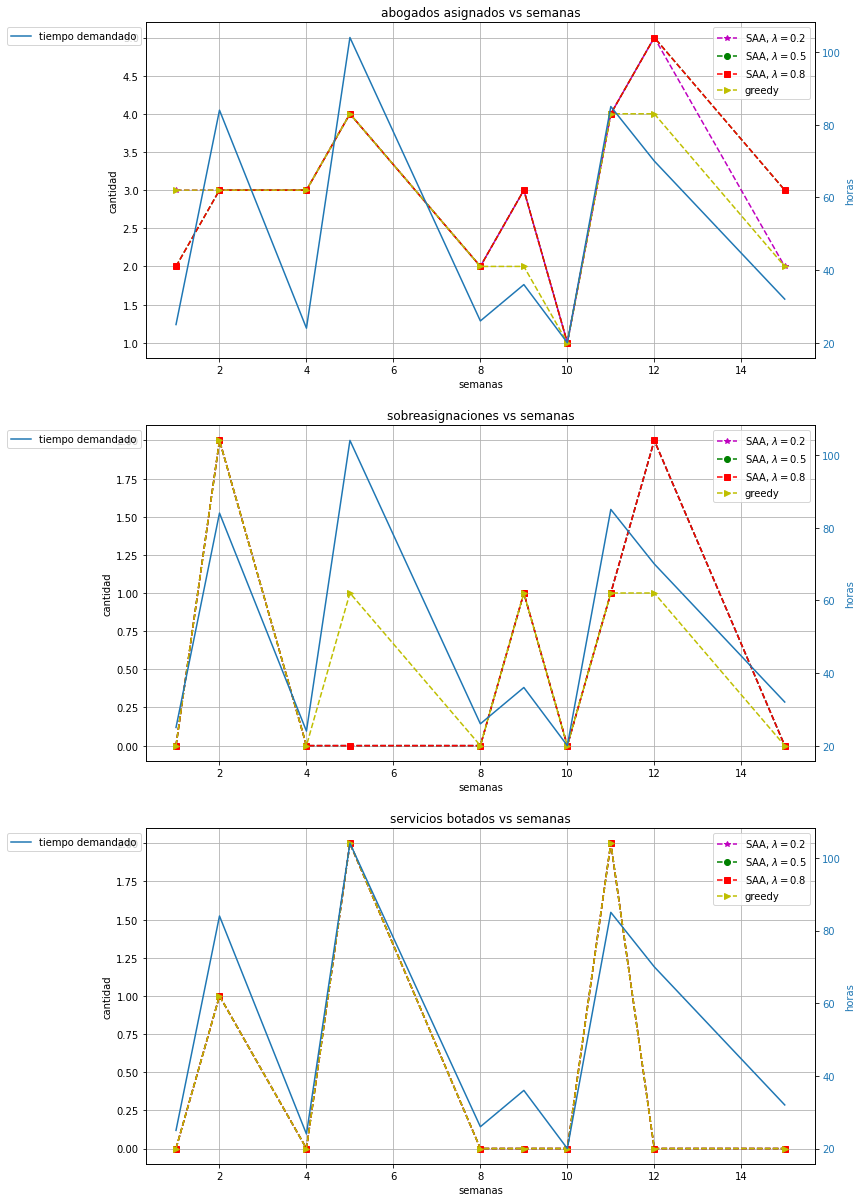

In [376]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [483]:
columns = [f"w{week}" for week in weeks]
index = pd.MultiIndex.from_product([
    ["greedy", "saa-0.2", "saa-0.5", "saa-0.8"],
    ["rating", "penalized rating", "abogados asignados", 
     "sobreasignaciones", "servicios botados"]
])

index = pd.MultiIndex.from_tuples([("servicios totales", ""), ("tiempo demandado", "")]
                                  + list(index))

table125 = pd.DataFrame(columns=columns, index=index)
table125.loc["saa-0.2"].iloc[2:]
table125.loc[("servicios totales", "")] = services[rate, lamb][:, 0]
table125.loc[("tiempo demandado", "")] = services[rate, lamb][:, 1]

for lamb in lambs:
    key1 = f"saa-{lamb}"
    table125.loc[(key1, "rating"), :] = saa_fos[rate, lamb]
    table125.loc[(key1, "penalized rating"), :] = saa_pfos[rate, lamb]
    table125.loc[(key1, "abogados asignados"), :] = saa_ass[rate, lamb][:, 0]
    table125.loc[(key1, "sobreasignaciones"), :] = saa_ass[rate, lamb][:, 1]
    table125.loc[(key1, "servicios botados"), :] = saa_ass[rate, lamb][:, 2]
    
table125.loc[("greedy", "rating"), :] = saa_fos[rate, lamb]
table125.loc[("greedy", "penalized rating"), :] = greedy_pfos[rate, lamb]
table125.loc[("greedy", "abogados asignados"), :] = greedy_ass[rate, lamb][:, 0]
table125.loc[("greedy", "sobreasignaciones"), :] = greedy_ass[rate, lamb][:, 1]
table125.loc[("greedy", "servicios botados"), :] = greedy_ass[rate, lamb][:, 2]
    
idx = pd.IndexSlice
table125.iloc[2:, :].loc[(slice(None), "servicios botados"), :]

,,w1,w2,w4,w5,w8,w9,w10,w11,w12,w15
greedy,servicios botados,0,1,0,2,0,0,0,2,0,0
saa-0.2,servicios botados,0,1,0,2,0,0,0,2,0,0
saa-0.5,servicios botados,0,1,0,2,0,0,0,2,0,0
saa-0.8,servicios botados,0,1,0,2,0,0,0,2,0,0


In [484]:
table125.iloc[2:, :].loc[(slice(None), "abogados asignados"), :]

,,w1,w2,w4,w5,w8,w9,w10,w11,w12,w15
greedy,abogados asignados,3,3,3,4,2,2,1,4,4,2
saa-0.2,abogados asignados,3,3,3,4,2,3,1,4,5,2
saa-0.5,abogados asignados,2,3,3,4,2,3,1,4,5,3
saa-0.8,abogados asignados,2,3,3,4,2,3,1,4,5,3


In [485]:
table125.iloc[2:, :].loc[(slice(None), "sobreasignaciones"), :]

,,w1,w2,w4,w5,w8,w9,w10,w11,w12,w15
greedy,sobreasignaciones,0,2,0,1,0,1,0,1,1,0
saa-0.2,sobreasignaciones,0,2,0,0,0,1,0,1,2,0
saa-0.5,sobreasignaciones,0,2,0,0,0,1,0,1,2,0
saa-0.8,sobreasignaciones,0,2,0,0,0,1,0,1,2,0


### rate = 4 ###

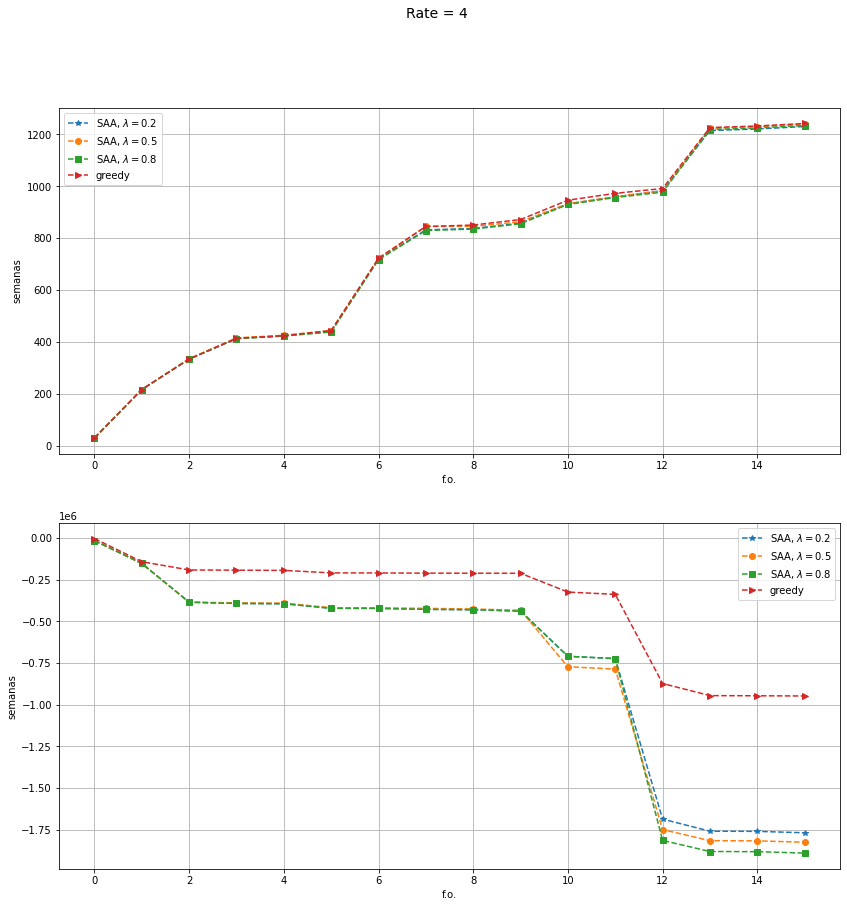

In [355]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 14))

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())

symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])
    ax3.plot(weeks, saa_pfos[rate, lamb], symbols[i])

ax3.plot(weeks, greedy_pfos[rate, lamb], "-->")
ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 

ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_ylabel('semanas')
ax1.set_xlabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_ylabel('semanas')
ax1.set_xlabel('f.o.')

ax3.grid()
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_ylabel('semanas')
ax3.set_xlabel('f.o.')
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_ylabel('semanas')
ax3.set_xlabel('f.o.')
fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

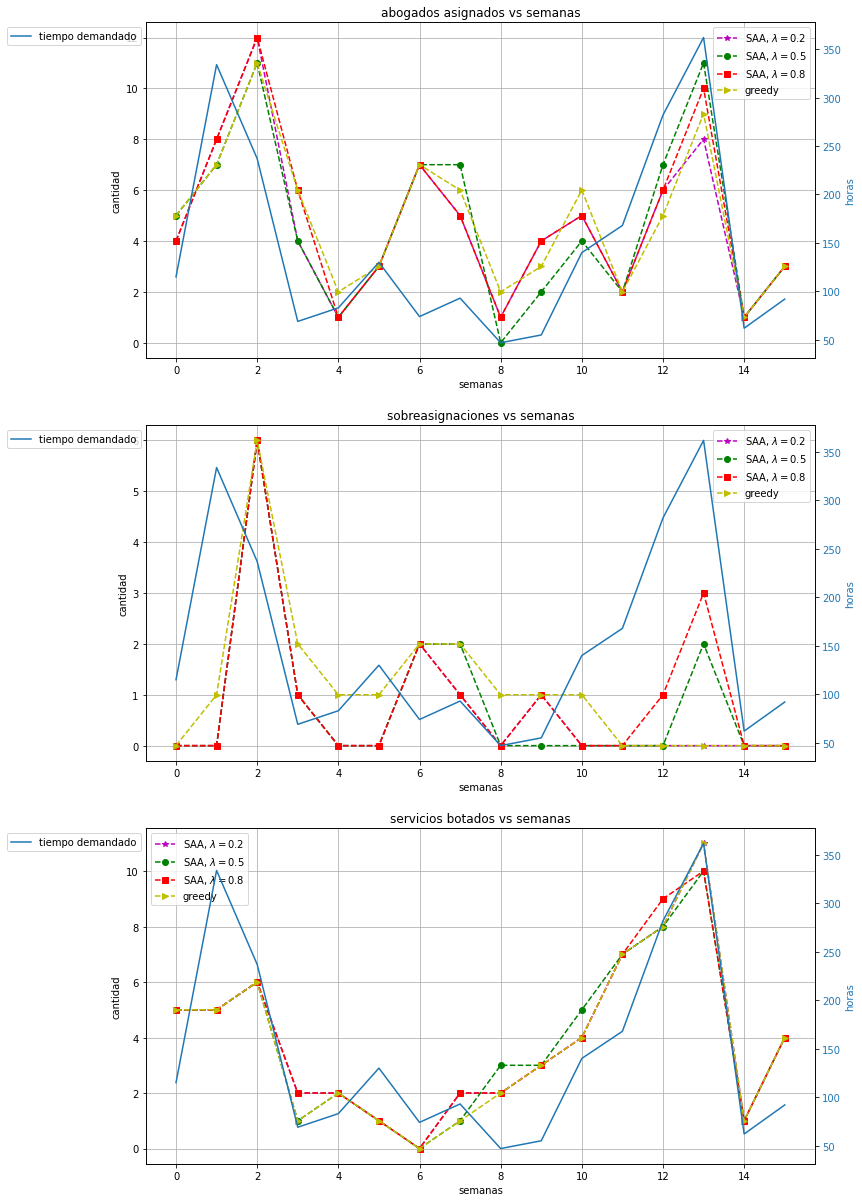

In [357]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

# 40 #

In [359]:
with open('results/40/assignments.pickle', 'rb') as file:
    assignments = pickle.load(file)
    
with open('results/40/spr.pickle', 'rb') as file:
    spr = pickle.load(file)

with open('results/40/sr.pickle', 'rb') as file:
    sr = pickle.load(file)
    
with open('results/40/time_lawyers.pickle', 'rb') as file:
    lawyers_time = pickle.load(file)
    
mode1, mode2 = 'saa', 'greedy'

In [360]:
greedy_info, saa_info, services = get_data(assignments, spr, sr, lawyers_time, sa, weeks)
greedy_fos, greedy_pfos, greedy_ass = greedy_info
saa_fos, saa_pfos, saa_ass = saa_info

### rate = 1.25 ###

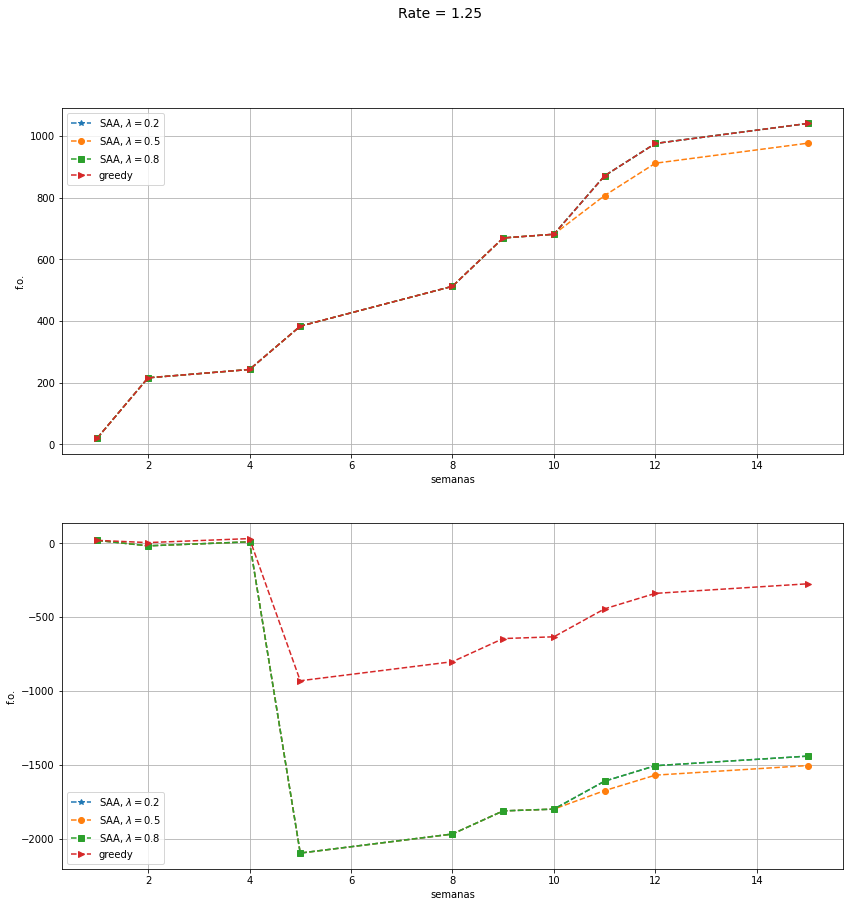

In [361]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 14))

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])
    
    ax3.plot(weeks, saa_pfos[rate, lamb], symbols[i])

ax3.plot(weeks, greedy_pfos[rate, lamb], "-->")
ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

ax3.grid()
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

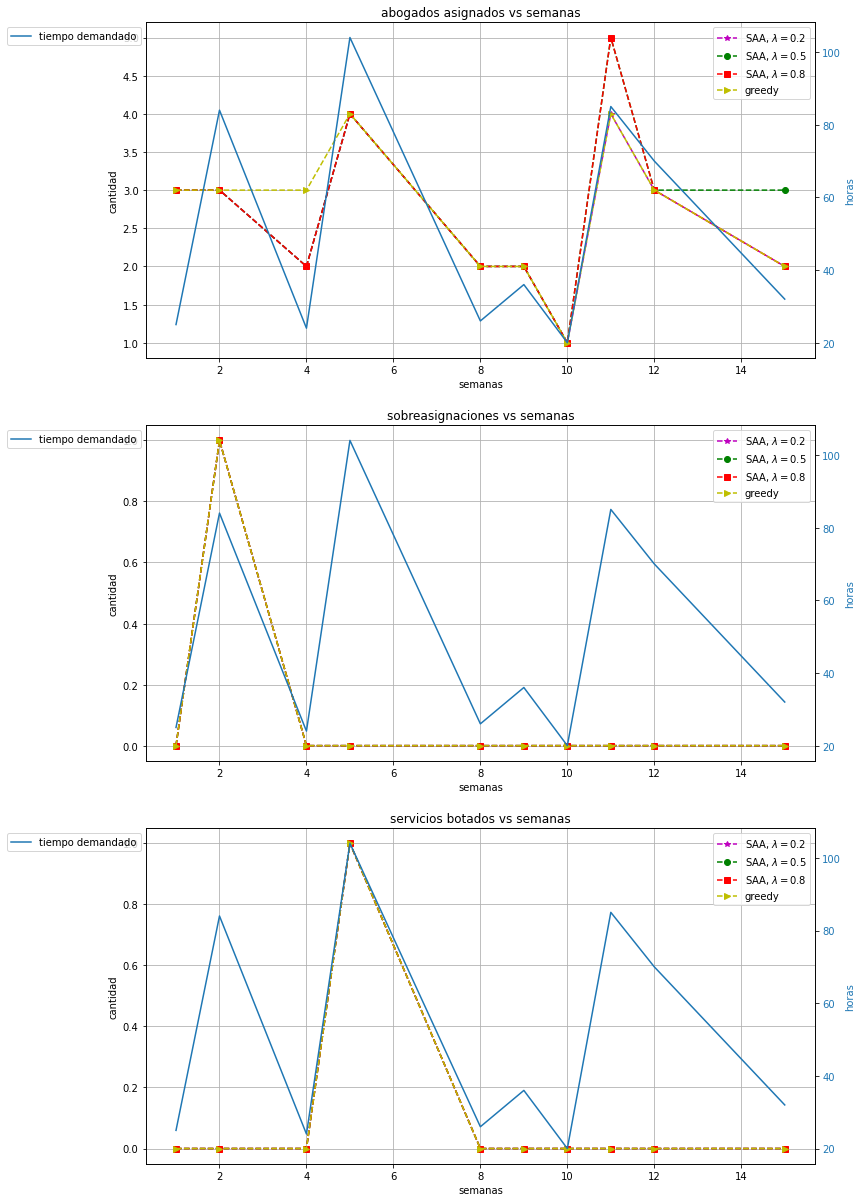

In [362]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

### rate = 4 ###

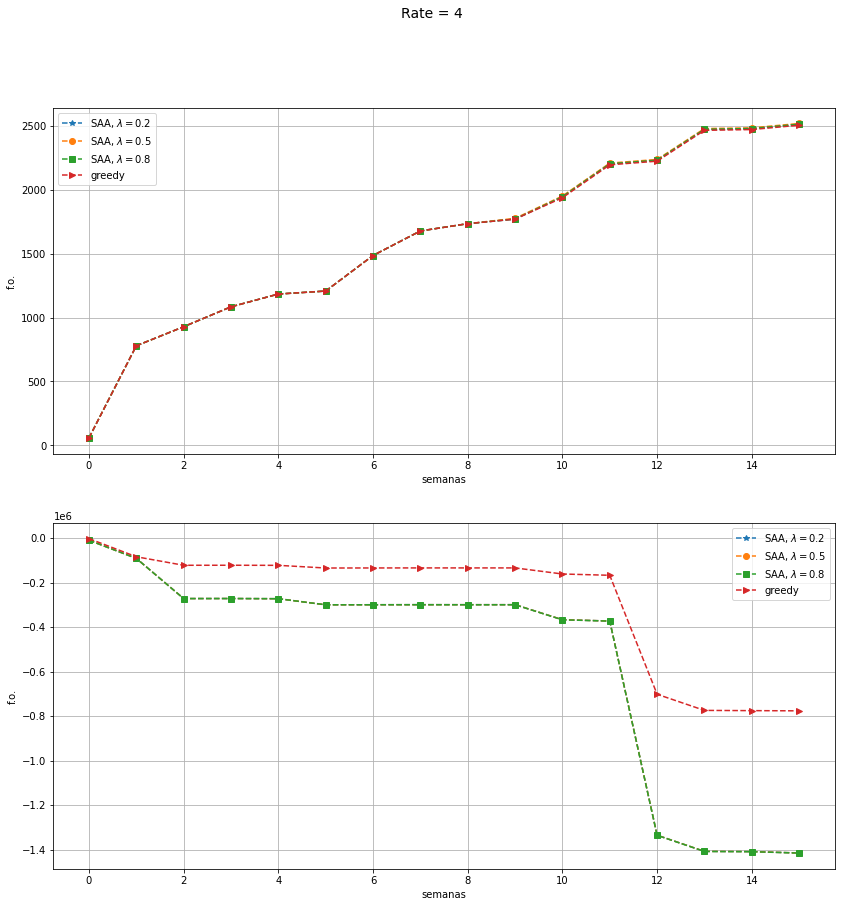

In [363]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 14))

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])
    
    ax3.plot(weeks, saa_pfos[rate, lamb], symbols[i])

ax3.plot(weeks, greedy_pfos[rate, lamb], "-->")
ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

ax3.grid()
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax3.set_xlabel('semanas')
ax3.set_ylabel('f.o.')
fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

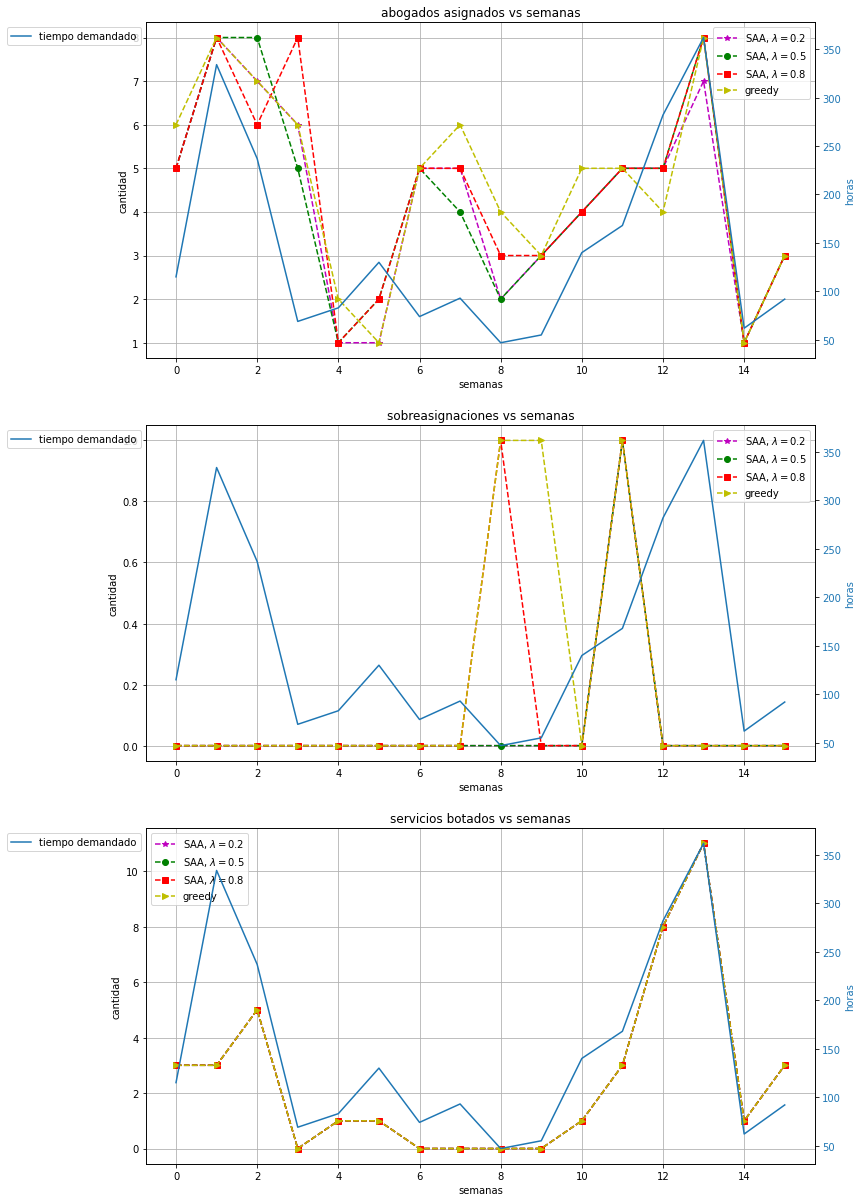

In [364]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [371]:
for l in assignments[4][0.8][greedy]: 
    print("week", l)
    print(assignments[4][0.8][greedy][l])
    print(assignments[4][0.2][saa][l])
    print(assignments[4][0.5][saa][l])
    print(assignments[4][0.8][saa][l])
    print()

week 0
[[19], [12], [19], [], [], [], [13], [0], [3], [14]]
[[19], [4], [19], [], [], [], [3], [2], [3], [14]]
[[19], [4], [19], [], [], [], [3], [1], [3], [14]]
[[19], [4], [19], [], [], [], [3], [0], [3], [14]]

week 1
[[10], [], [], [], [2], [12], [12], [12], [17], [17], [9], [3], [1], [0], [2], [0]]
[[10], [], [], [], [2], [12], [12], [12], [17], [17], [9], [3], [1], [0], [2], [0]]
[[10], [], [], [], [0], [12], [12], [12], [17], [17], [9], [3], [2], [0], [1], [0]]
[[10], [], [], [], [2], [12], [12], [12], [17], [17], [9], [3], [1], [0], [2], [0]]

week 2
[[19], [4], [], [], [], [], [4], [3], [5], [2], [], [14], [17], [17]]
[[19], [4], [], [], [], [], [3], [4], [6], [0], [], [16], [16], [17]]
[[19], [4], [], [], [], [], [3], [4], [13], [0], [], [14], [17], [16]]
[[19], [4], [], [], [], [], [4], [4], [5], [0], [], [15], [17], [15]]

week 3
[[4], [3], [15], [5], [3], [17], [17], [14]]
[[3], [3], [17], [22], [20], [16], [17], [14]]
[[3], [4], [16], [22], [22], [14], [16], [14]]
[[4], [